In [1]:
import numpy as np
from numba import jit, njit, prange
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix, dia_array
from mylinalg import solveLowerTriangular, solveUpperTriangular, lu, lu_solve
import time


In [2]:
@njit(parallel=True)
def loop_kernel(N,A,d,o,z,period):
    for i in prange(N):
        for j in prange(N):
            if (i==j):
                submatrix = d
            elif (abs(i-j)==1):
                submatrix = o
            else:
                submatrix = z

            for ii in prange(N):
                for jj in prange(N):
                    A[i*N+ii,j*N+jj] = submatrix[ii,jj]

    if period:
        for k in prange(N**2):
            i = k % N; j = k // N
            if i == 0:
                A[k,(j+1)*N-1] = -1.
            if i == (N-1):
                A[k,j*N] = -1.
            if j == 0:
                A[k,N*(N-1)+i] = -1.
            if j == (N-1):
                A[k,i] = -1.

    return A

def generate_the_laplace_matrix_with_size(N=4, period=False):
    """
    assume sqrt(N) is an integer.
    period: -1 <-> N-1, 0 <-> N
    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))
    
    def init_1_4_matrix(n):
        ex = np.ones(n)
        data = np.array([-ex, 4 * ex, -ex])
        offsets = np.array([-1, 0, 1])
        return dia_matrix((data, offsets), shape=(n, n)).toarray()

    def init_one_matrix(n):
        return -np.identity(n)

    def init_zero_matrix(n):
        return np.zeros((n,n))
    
    d_matrix = init_1_4_matrix(N)
    o_matrix = init_one_matrix(N)
    z_matrix = init_zero_matrix(N)
    
    A = loop_kernel(N,A,d_matrix,o_matrix,z_matrix, period)
    return A

def generate_the_rhs_vector_with_size(N=4):
    b = np.zeros(N*N)
    b[-N:] = 1
    return b

def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u

def convert_vector(A):
    usize = A.shape[0]**2
    b = A.reshape(int(usize),1).transpose()[0,:]
    return b

def solve_laplace(b, N=16, period=False):
    A = generate_the_laplace_matrix_with_size(N=N, period=period)
    #x = linalg.solve(A,b) # use scipy
    x = lu_solve(A,b)      # use our solver
    u = convert_solution(x)
    return u


# problem 1

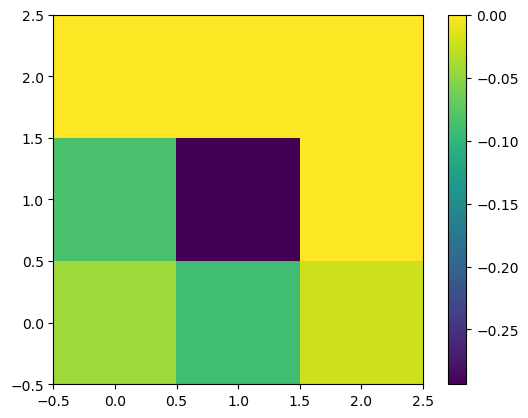

In [3]:
b = np.array([0,0,0,0,-1,0,0,0,0])
u = solve_laplace(b,3, period=False)
plt.imshow(u.T,origin="lower")
plt.colorbar()

# problem 2

Text(0.5, 1.0, 'source')

<Figure size 640x480 with 0 Axes>

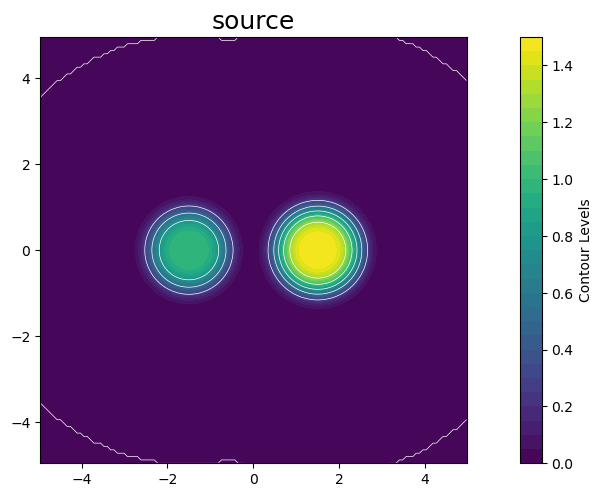

In [4]:
N = 128
lim = 5
dx = lim*2/N
x = np.linspace(-lim, lim, N+1)
x = (x[:-1]+x[1:])/2
X,Y = np.meshgrid(x,x)
r1 = (X+1.5)**2 + Y**2
r2 = (X-1.5)**2 + Y**2
rho = np.exp(-1.25*r1**2)+1.5*np.exp(-r2**2)


plt.figure(1)
fig, ax = plt.subplots()
contourf = ax.contourf(X, Y, rho, levels=30)
contour = ax.contour(X, Y, rho, levels=6, linewidths=0.5, colors='w')
# 添加 colorbar 只对 contour
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label('Contour Levels')
plt.axis("square")
plt.tight_layout()
plt.title("source", fontsize=18)


In [3]:
from scipy.linalg import lu_factor, lu_solve
# use my solvor is too slow... the previous problem uses my solver.

In [6]:
#potential = solve_laplace(source, N, period=True)
source = -convert_vector(rho*dx**2)
lu, piv = lu_factor(generate_the_laplace_matrix_with_size(128,True))
potential = lu_solve((lu,piv), source)
potential = convert_solution(potential)

Text(0.5, 1.0, 'potential')

<Figure size 640x480 with 0 Axes>

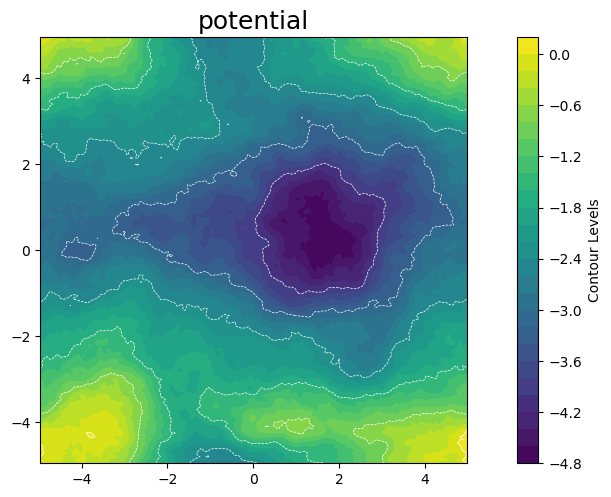

In [12]:
plt.figure(2)
fig, ax = plt.subplots()
contourf = ax.contourf(X, Y, (potential-potential[0,0]).T, levels=30)
contour = ax.contour(X, Y, (potential-potential[0,0]).T, levels=6, linewidths=0.5, colors='w')
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label('Contour Levels')
plt.axis("square")
plt.tight_layout()
plt.title("potential", fontsize=18)

In [3]:
def generate_mesh(nx, ny, buff=1, 
                  xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0, period=False):
    """
    Generate 2D mesh grids for solving Laplace equation.

    nx : int
        Number of grid points in x direction.
    ny : int
        Number of grid points in y direction.
    buff : int
        Number of ghost cells around the domain.

    Returns
    
    u : 2D numpy array
        Initial guess. 
    x : 2D numpy array
        Mesh grid for x.
    y : 2D numpy array
        Mesh grid for y.
    """
    u = np.zeros((nx+2*buff, ny+2*buff))
    if period:
        dx = (xmax-xmin)/(nx+2*(buff-1))
        dy = (ymax-ymin)/(ny+2*(buff-1))
        x = np.linspace(xmin-dx/2, xmax+dx/2, nx+2*buff)
        y = np.linspace(ymin-dy/2, ymax+dy/2, ny+2*buff)

    else:
        x = np.linspace(xmin, xmax, nx+2*buff)
        y = np.linspace(ymin, ymax, ny+2*buff)
        dx = x[1] - x[0]
        dy = y[1] - y[0]
    return u, x, y, dx, dy

def background(x,y):
    X,Y = np.meshgrid(y,x)
    r1 = (X+1.5)**2 + Y**2
    r2 = (X-1.5)**2 + Y**2
    rho = np.exp(-1.25*r1**2)+1.5*np.exp(-r2**2)
    return rho


In [4]:

@njit(parallel=True)
def jacobi(u, source, dx, uold, nx, ny):
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            u[i,j] = 0.25*(uold[i-1,j] + uold[i+1,j] + uold[i,j-1] + uold[i,j+1] - (dx**2)*source[i,j])
    return u

@njit(parallel=True)
def gauss_seidel(u, source, dx, nx, ny):
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            # first and second term are new.
            u[i,j] = 0.25*(u[i-1,j] + u[i,j-1] + u[i+1,j] + u[i,j+1] - (dx**2)*source[i,j])
    return u

@njit(parallel=True)
def successive_over_relax(u, source, dx, uold, nx, ny, w):
    for j in prange(1, ny+-1):
        for i in prange(1, nx-1):
            # first and second term are new.
            u[i,j] = 0.25*(u[i-1,j] + u[i,j-1] + u[i+1,j] + u[i,j+1] - (dx**2)*source[i,j])
    u = (1-w)*uold+w*u
    return u

@njit()
def update_bc(u):
    u[0,:] = u[-2,:] # left boundary
    u[-1,:] = u[1,:] # right boundary
    u[:,0] = u[:,-2] # bottom boundary
    u[:,-1] = u[:,1] # top boundary
    return u

@njit(parallel=True)
def relax(u, source, tolerance, maxiter=1e6, w=1.2, method="Jacobi"):
    """
    Relax the solution using Jacobi method.

    Parameters
    ----------
    u : 2D numpy array
        Initial guess.
    tolerance : float
        Tolerance for convergence.
    maxiter : int
        Maximum number of iterations.
    w: float
        Used in SOR method.
    method: str
        "Jacobi", "GS", "SOR".
    """
    nx, ny = u.shape # inculde ghost cells
    u = update_bc(u)

    errors = []
    iterations = []

    for n in range(maxiter):
        uold = u.copy()
        if method == "Jacobi":
            u = jacobi(u, source, dx, uold, nx, ny)
        elif method == "GS":
            u = gauss_seidel(u, source, dx, nx, ny)
        elif method == "SOR":
            u = successive_over_relax(u, source, dx, uold, nx, ny, w)
        err = 0
        for i in prange(1,nx-1):
            for j in prange(1,ny-1):
                u1 = u[i,j]
                u2 = uold[i,j]
                err0 = (u1 - u2)**2
                err += err0

        err = np.sqrt(err)/nx/ny
        errors.append(err)
        iterations.append(n)
        if err < tolerance:
            print("err:", err, n, "end!")
            break
        
    return u, iterations, errors



In [9]:
n = 128
u0, x, y, dx, dy = generate_mesh(n, n, xmin=-5, xmax=5, ymin=-5, ymax=5, period=True)
u = u0.copy()
rho = background(x,y)
u, itt_jocobi, err_jocobi = relax(u, rho, tolerance=1e-6, maxiter=1_000_000, method="Jacobi")

u = u0.copy()
u, itt_gs, err_gs = relax(u, rho, tolerance=1e-6, maxiter=1_000_000, method="GS")
u = u0.copy()
u, itt_sor_1, err_sor_1 = relax(u, rho, tolerance=1e-6, w=1.2, maxiter=1_000_000, method="SOR")
u = u0.copy()
u, itt_sor_2, err_sor_2 = relax(u, rho, tolerance=1e-6, w=1.5, maxiter=1_000_000, method="SOR")


err: 9.998387684522084e-07 1093 end!
err: 9.996479854449903e-07 1652 end!
err: 9.994160253174795e-07 1633 end!
err: 9.995959721279966e-07 1557 end!


In [10]:
u = u0.copy()
u, itt_sor_3, err_sor_3 = relax(u, rho, tolerance=1e-6, w=1.8, maxiter=1_000_000, method="SOR")

''''''

In [7]:
plt.figure()
plt.plot(itt_jocobi, err_jocobi, label = "jacobi")
plt.plot(itt_gs, err_gs, label = "GS")
plt.plot(itt_sor_1, err_sor_1, label = "SOR, w=1.2")
plt.plot(itt_sor_2, err_sor_2, label = "SOR, w=1.5")
plt.plot(itt_sor_3, err_sor_3, label = "SOR, w=1.8")
plt.yscale("log")
plt.xlabel("iterations", fontsize = 18)
plt.ylabel("error", fontsize = 18)
plt.legend()
plt.tight_layout()

128


In [31]:
n=128
u, x, y, dx, dy = generate_mesh(n, n, xmin=-5, xmax=5, ymin=-5, ymax=5, period=True)
X,Y = np.meshgrid(y,x)
r1 = (X+1.5)**2 + Y**2
r2 = (X-1.5)**2 + Y**2
uold = u.copy()
rho = background(x,y)

nx = n+2
ny = n+2
print(X[20,0], Y[20,0])
print(np.exp(-r1[20,0]**2))
print(r2[20,0])
print(rho[20,0])
u = jacobi(u, rho, dx, uold, nx, ny)

-5.0390625 -3.4765625
8.662330819253226e-264
54.8458251953125
0.0
0.0


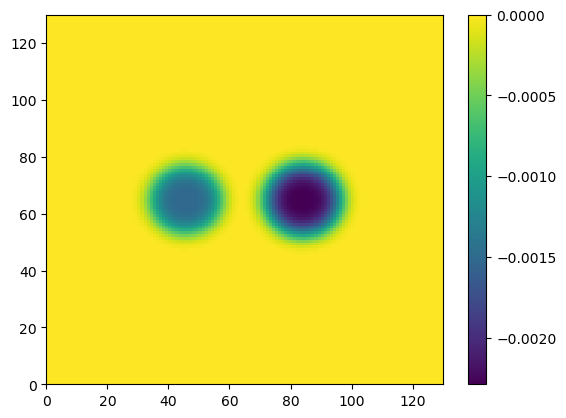

In [32]:
plt.pcolor(u)
plt.colorbar()